# Intention: cuantas proteinas de LLPS estan asociadas a cada enfermedad?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn2_unweighted, venn3, venn3_circles
import seaborn as sns
import re

In [2]:
import os
os.getcwd()

'/home/alvaro/Documents/mutations/scripts/mesh'

In [3]:
# Tables from DisPhase
cross_reference= pd.read_csv('../../db_tables/cross_reference.tsv', sep= '\t')
disease_has_synonyms = pd.read_csv('../../db_tables/disease_has_synonyms.tsv', sep= '\t')
disease = pd.read_csv('../../db_tables/disease.tsv', sep= '\t')
mutation_has_disease = pd.read_csv('../../db_tables/mutation_has_disease.tsv', sep= '\t')

In [4]:
protein = pd.read_csv('../../db_tables/protein.tsv', sep= '\t')

In [5]:
mutation = pd.read_csv('../../db_tables/mutation_new.tsv.gz', sep= '\t', compression= 'gzip')

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# Diseases from DisPhase with cross references
disease_has_synonyms = disease_has_synonyms.merge(cross_reference).drop(columns='id_cross')

In [7]:
# Mutations with their diseases
mutation_has_disease = mutation_has_disease.merge(disease)

In [8]:
mutation_has_disease.id_mutation.value_counts()

1560239    296
1560237    246
1169031    243
151020     194
151032     184
          ... 
584429       1
584336       1
584198       1
584196       1
1560377      1
Name: id_mutation, Length: 1597034, dtype: int64

In [9]:
# MeSH data with ui identifiers
# Downloaded from https://nlmpubs.nlm.nih.gov/projects/mesh/MESH_FILES/
# and preprocessed in scripts/mesh/01_clean_mesh.pl
mesh_df = pd.read_csv('../../raw_data/d2021_processed.tsv', sep='\t').drop(columns= 'cross_reference') # these are not cross ref
mesh_df

,ui,mesh_name,tree
0,D000001,Calcimycin,D03.633.100.221.173
1,D000002,Temefos,"D02.705.400.625.800,D02.705.539.345.800,D02.88..."
2,D000003,Abattoirs,"J01.576.423.200.700.100,J03.540.020"
3,D000004,Abbreviations as Topic,L01.559.598.400.556.131
4,D000005,Abdomen,A01.923.047
...,...,...,...
29911,D066309,Public Service Announcement,V02.736
29912,D066310,Digital Divide,L01.143.230.500
29913,D066328,Ventral Striatum,A08.186.211.200.885.287.249.487.775
29914,D066329,Protein Aggregates,D05.875


In [10]:
mesh_df.mesh_name.sample(10)

1009                        Oxysterols
16254               Trypanosoma lewisi
4003                    Benzimidazoles
20952             Photoaffinity Labels
29158    Junctional Adhesion Molecules
17451                         Djibouti
170               Late Onset Disorders
6909            Electrophoresis, Paper
17215                 Zona Glomerulosa
8933                        Homozygote
Name: mesh_name, dtype: object

## venn diagram - to see how much terms from different ontologies overlaps

In [11]:
disease_has_synonyms.cross_name.value_counts()

SNOMEDCT_US        15051
MSH                11436
OMIM               10893
NCI                 6991
CHV                 5346
                   ...  
NCI_CDISC-GLOSS        1
PNDS                   1
HL7V2.5                1
MTHICPC2ICD10AE        1
NCI_GAIA               1
Name: cross_name, Length: 84, dtype: int64

In [12]:
cui_mesh = set(disease_has_synonyms[disease_has_synonyms.cross_name == "MSH"].cui)
cui_snomed = set(disease_has_synonyms[disease_has_synonyms.cross_name == "SNOMEDCT_US"].cui)
cui_omim = set(disease_has_synonyms[disease_has_synonyms.cross_name == "OMIM"].cui)
cui_nci = set(disease_has_synonyms[disease_has_synonyms.cross_name == "NCI"].cui)
cui_chv = set(disease_has_synonyms[disease_has_synonyms.cross_name == "CHV"].cui)

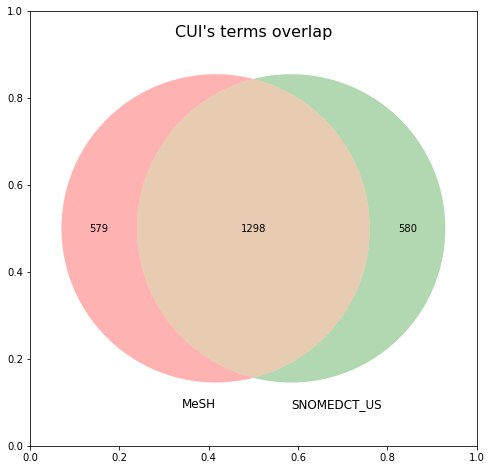

In [13]:
plt.subplots(figsize=(8,8))
ax = plt.axes()
#ax.set_facecolor("white")
plt.axis('off')
venn2(subsets= [cui_mesh, cui_snomed], set_labels=["MeSH", "SNOMEDCT_US"], alpha= 0.3)
plt.title("CUI's terms overlap", size=16)
plt.show()

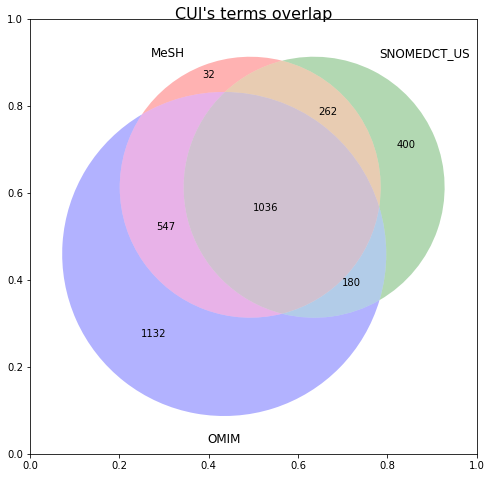

In [14]:
plt.subplots(figsize=(8,8))
ax = plt.axes()
#ax.set_facecolor("white")
ax.axis('off')
venn3(subsets= [cui_mesh, cui_snomed, cui_omim], set_labels=["MeSH", "SNOMEDCT_US", "OMIM"], alpha= 0.3)
plt.title("CUI's terms overlap", size=16)
plt.show()

In [15]:
disease_has_synonyms.cross_name.value_counts()[:10]

SNOMEDCT_US    15051
MSH            11436
OMIM           10893
NCI             6991
CHV             5346
RCD             4220
MEDCIN          3820
MDR             3267
SNMI            2527
HPO             2426
Name: cross_name, dtype: int64

In [16]:
#disease_has_synonyms[disease_has_synonyms.cross_name == 'SNOMEDCT_US'].rename(columns= {'code': 'ui'})

### Concept Unique Identifiers (CUI)  
A concept is a meaning. A meaning can have many different names. A key goal of Metathesaurus construction is to understand the intended meaning of each name in each source vocabulary and to link all the names from all of the source vocabularies that mean the same thing (the synonyms). CUI contain the letter C followed by seven numbers.

In [17]:
mutation_has_disease.head()

,id_mutation,cui,disease_name
0,1,C0917800,"Epilepsy, Myoclonic, Infantile"
1,2,C0917800,"Epilepsy, Myoclonic, Infantile"
2,3,C0917800,"Epilepsy, Myoclonic, Infantile"
3,4,C0917800,"Epilepsy, Myoclonic, Infantile"
4,5,C0917800,"Epilepsy, Myoclonic, Infantile"


In [18]:
mutation_has_disease.disease_name.value_counts()

Cutaneous Melanoma                         175137
Adenocarcinoma of large intestine          142650
Endometrial Endometrioid Adenocarcinoma    127794
Adenocarcinoma of colon                    106020
Adenocarcinoma of lung (disorder)           97628
                                            ...  
Arnold Chiari Malformation                      1
NARCOLEPSY 7                                    1
Expressive language delay                       1
Cerebral dysmyelination                         1
Bladder Sarcoma                                 1
Name: disease_name, Length: 4051, dtype: int64

<AxesSubplot:>

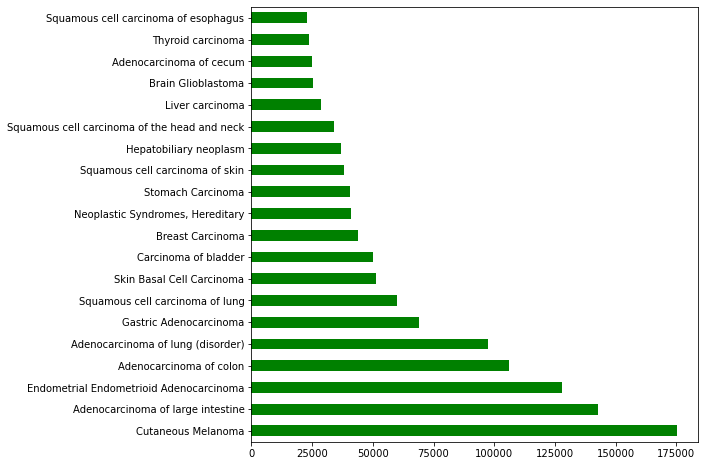

In [19]:
plt.subplots(figsize= (8,8))
mutation_has_disease.disease_name.value_counts()[:20].plot(kind= 'barh', color= 'green')

### Paint each bar by mutation source

In [20]:
mutation_has_source = pd.read_csv('../../db_tables/mutation_has_source_new.tsv', sep= '\t').merge(
    pd.read_csv('../../db_tables/source.tsv', sep= '\t')
)

In [40]:
mutation_has_source.id_mutation.nunique()

1660059

In [41]:
mut_dis_source = mutation_has_disease.merge(mutation_has_source[['id_mutation', 'source']], how='left')
mut_dis_source.head()

,id_mutation,cui,disease_name,source
0,1,C0917800,"Epilepsy, Myoclonic, Infantile",clinvar
1,2,C0917800,"Epilepsy, Myoclonic, Infantile",clinvar
2,3,C0917800,"Epilepsy, Myoclonic, Infantile",clinvar
3,4,C0917800,"Epilepsy, Myoclonic, Infantile",clinvar
4,5,C0917800,"Epilepsy, Myoclonic, Infantile",clinvar


In [37]:
mut_dis_source.id_mutation.duplicated().sum()

989690

In [38]:
mut_dis_source.shape[0] - mut_dis_source.id_mutation.duplicated().sum()

1597034

In [22]:
mut_dis_source.source.value_counts()

cosmic      1819481
disgenet     401726
clinvar      311358
uniprot       54159
Name: source, dtype: int64

In [23]:
diseases_by_source = mut_dis_source.pivot_table(columns= 'source', index='disease_name', aggfunc='size')#.sort_values()[:10].plot.barh(stacked= True)

In [24]:
diseases_by_source['suma'] = diseases_by_source.sum(1)

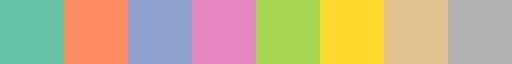

In [25]:
plt.cm.get_cmap('Set2')

In [26]:
# Colors for barplot
import matplotlib
cmap = plt.cm.get_cmap('Set2')

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

#66c2a5
#fc8d62
#8da0cb
#e78ac3
#a6d854
#ffd92f
#e5c494
#b3b3b3


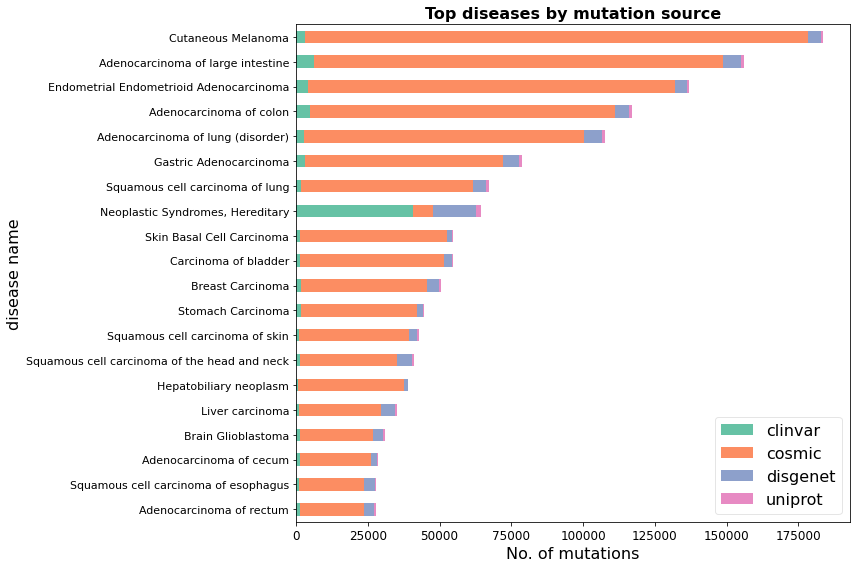

In [44]:
# Top diseases by source
diseases_by_source.sort_values('suma', ascending= False).drop(columns='suma')[:20].iloc[::-1].plot.barh(
    stacked= True, figsize= (12,8), color = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
)
plt.title("Top diseases by mutation source", size=16, fontweight='bold')
plt.xlabel("No. of mutations", fontsize= 16)
plt.ylabel("disease name", fontsize= 16)
plt.yticks(fontsize= 11)
plt.xticks(fontsize= 12)
plt.legend(fancybox= True, framealpha=0.5, prop= {'size': 16})
plt.tight_layout()
#plt.savefig("top_diseases_source.png", dpi= 300, transparent= True)
plt.show()

### Exclude Cosmic data

In [28]:
mut_dis_source.shape

(2586724, 4)

In [29]:
mut_dis_source_nocosmic = mut_dis_source[mut_dis_source.source != 'cosmic']

In [30]:
mut_dis_source_nocosmic

,id_mutation,cui,disease_name,source
0,1,C0917800,"Epilepsy, Myoclonic, Infantile",clinvar
1,2,C0917800,"Epilepsy, Myoclonic, Infantile",clinvar
2,3,C0917800,"Epilepsy, Myoclonic, Infantile",clinvar
3,4,C0917800,"Epilepsy, Myoclonic, Infantile",clinvar
4,5,C0917800,"Epilepsy, Myoclonic, Infantile",clinvar
...,...,...,...,...
2586719,217129,C0349666,Bladder Sarcoma,disgenet
2586720,217129,C0349666,Bladder Sarcoma,disgenet
2586721,217129,C0349666,Bladder Sarcoma,disgenet
2586722,217129,C0349666,Bladder Sarcoma,uniprot


In [31]:
mut_source_nocosmic = mut_dis_source_nocosmic.pivot_table(columns= 'source', index='disease_name', aggfunc='size')

In [32]:
mut_source_nocosmic['suma'] = mut_source_nocosmic.sum(1)

In [33]:
mut_source_nocosmic

source,clinvar,disgenet,uniprot,suma
disease_name,,,,
"2,4-Dienoyl-CoA Reductase Deficiency",2.0,NaN,NaN,2.0
2-methyl-3-hydroxybutyric aciduria,4.0,1.0,NaN,5.0
3 beta-Hydroxysteroid dehydrogenase deficiency,30.0,10.0,NaN,40.0
"3-@METHYLGLUTACONIC ACIDURIA, TYPE I",36.0,3.0,1.0,40.0
"3-@METHYLGLUTACONIC ACIDURIA, TYPE V",9.0,NaN,NaN,9.0
...,...,...,...,...
squamous cell carcinoma of urethra,1.0,25.0,2.0,28.0
succinic semialdehyde dehydrogenase deficiency,188.0,12.0,9.0,209.0
synovial sarcoma,13.0,181.0,20.0,214.0


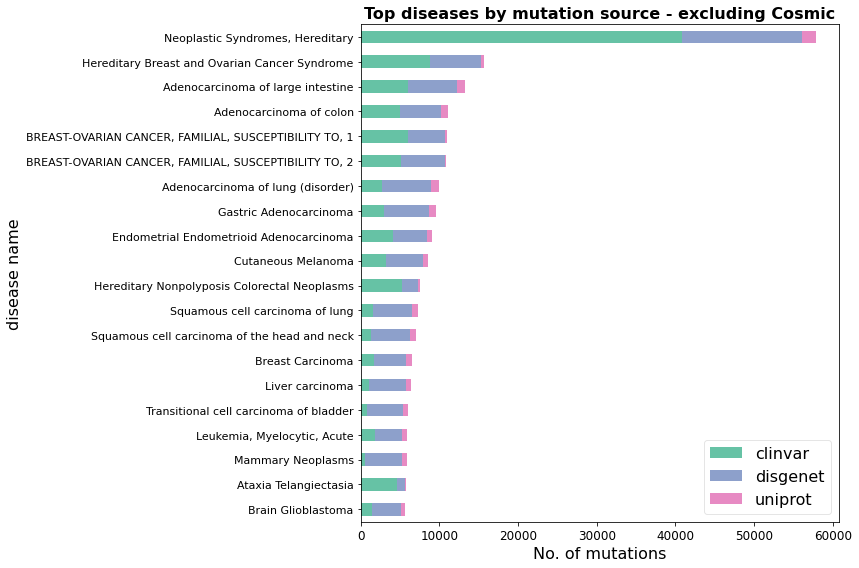

In [46]:
sns.set_palette('Set2')
mut_source_nocosmic.sort_values('suma', ascending= False).drop(columns='suma')[:20].iloc[::-1].plot.barh(
    stacked= True, figsize= (12,8), color = ['#66c2a5', '#8da0cb', '#e78ac3']
)
plt.title("Top diseases by mutation source - excluding Cosmic", size=16, fontweight='bold')
plt.xlabel("No. of mutations", fontsize= 16)
plt.ylabel("disease name", fontsize= 16)
plt.yticks(fontsize= 11)
plt.xticks(fontsize= 12)
plt.legend(fancybox= True, framealpha=0.5, prop= {'size': 16})
plt.tight_layout()
#plt.savefig("top_diseases_no_cosmic.png", dpi= 300, transparent= True)
plt.show()

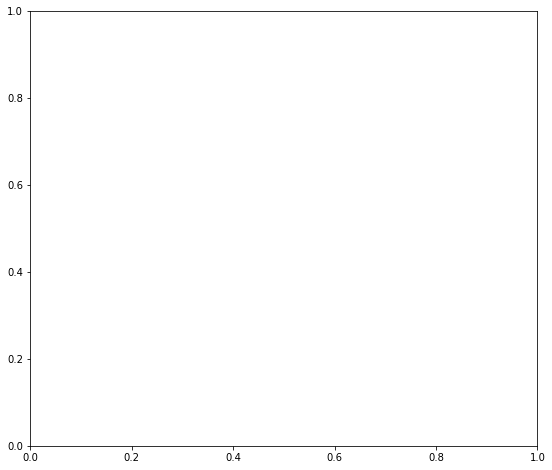

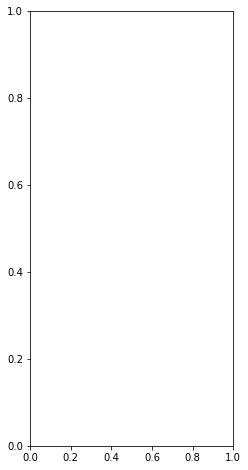

In [37]:
fig, ax = plt.subplots(figsize=(20,8))

plt.subplot(1,2,1) # with Cosmic
diseases_by_source.sort_values('suma', ascending= False).drop(columns='suma')[:20].plot.barh(stacked= True, figsize= (8,8), color = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])
plt.title("Top diseases by mutation source", size=16, fontweight='bold')
plt.xlabel("No. of mutations")


plt.subplot(1,2,2)

plt.show()

---

In [97]:
disease_has_synonyms

,cui,name,code,cross_name
0,C0000772,Multiple congenital anomalies,A90,ICPC
1,C0000772,Multiple cong anomalies,A90,ICPC
2,C0001973,Chronic alcohol abuse,P15,ICPC
3,C0002881,Hereditary hemolytic anemias,B78,ICPC
4,C0003811,Ectopic beats all types,K80,ICPC
...,...,...,...,...
89790,C0878684,SHORT syndrome,30068,DDB
89791,C1862322,Southeast Asian ovalocytosis,9416,DDB
89792,C1862322,Melanesian ovalocytosis,9416,DDB
89793,C1862322,Stomatocytic ovalocytosis,9416,DDB


In [73]:
# Get only Mesh entries
disphase_mesh = disease_has_synonyms[disease_has_synonyms.cross_name == 'MSH'].rename(columns= {'code': 'ui'})
# cui: is the UMLS concept identifier (CUI)
disphase_mesh

,cui,name,ui,cross_name
45380,C0000772,"Abnormalities, Multiple",D000015,MSH
45381,C0000772,Multiple Abnormalities,D000015,MSH
45382,C0000772,MULTIPLE ABNORM,D000015,MSH
45383,C0000772,ABNORM MULTIPLE,D000015,MSH
45384,C0000889,Acanthosis Nigricans,D000052,MSH
...,...,...,...,...
56811,C4759774,"Scapuloperoneal Myopathy, MYH7 Related",D020389,MSH
56812,C4759774,MYH7-Related Scapuloperoneal Myopathy,D020389,MSH
56813,C4759774,"Myopathy, MYH7-Related Scapuloperoneal",D020389,MSH
56814,C4759774,Scapuloperoneal Muscular Dystrophy,D020389,MSH


In [74]:
# Add data from Mesh ontology
disphase_mesh = disphase_mesh.merge(mesh_df, how= 'left').drop(columns= ['cross_name'])
disphase_mesh

,cui,name,ui,mesh_name,tree
0,C0000772,"Abnormalities, Multiple",D000015,"Abnormalities, Multiple",C16.131.077
1,C0000772,Multiple Abnormalities,D000015,"Abnormalities, Multiple",C16.131.077
2,C0000772,MULTIPLE ABNORM,D000015,"Abnormalities, Multiple",C16.131.077
3,C0000772,ABNORM MULTIPLE,D000015,"Abnormalities, Multiple",C16.131.077
4,C0000889,Acanthosis Nigricans,D000052,Acanthosis Nigricans,C17.800.621.430.530.100
...,...,...,...,...,...
11431,C4759774,"Scapuloperoneal Myopathy, MYH7 Related",D020389,"Muscular Dystrophy, Emery-Dreifuss","C05.651.534.500.350,C10.668.491.175.500.350,C1..."
11432,C4759774,MYH7-Related Scapuloperoneal Myopathy,D020389,"Muscular Dystrophy, Emery-Dreifuss","C05.651.534.500.350,C10.668.491.175.500.350,C1..."
11433,C4759774,"Myopathy, MYH7-Related Scapuloperoneal",D020389,"Muscular Dystrophy, Emery-Dreifuss","C05.651.534.500.350,C10.668.491.175.500.350,C1..."
11434,C4759774,Scapuloperoneal Muscular Dystrophy,D020389,"Muscular Dystrophy, Emery-Dreifuss","C05.651.534.500.350,C10.668.491.175.500.350,C1..."


In [75]:
# Separate different trees for the same disease
disphase_mesh.tree = disphase_mesh.tree.str.split(",")
disphase_mesh = disphase_mesh.explode("tree")
disphase_mesh.shape

(33356, 5)

In [76]:
disphase_mesh.sample(20)

,cui,name,ui,mesh_name,tree
8385,C1328840,"Syndrome, Autoimmune Lymphoproliferative",D056735,Autoimmune Lymphoproliferative Syndrome,C20.111.288
11169,C3888018,"Hyperinsulinism, Familial",D044903,Congenital Hyperinsulinism,C18.452.394.984.200
1790,C0019569,HIRSCHSPRUNGS DIS,D006627,Hirschsprung Disease,C06.405.469.158.701.439
3388,C0032580,"Colus, Familial Polyposis",D011125,Adenomatous Polyposis Coli,C06.301.371.411.307.090
4139,C0043207,DIDMOADUD,D014929,Wolfram Syndrome,C12.777.419.135.875
4688,C0162678,Multiple Neurofibroma,D017253,Neurofibromatoses,C10.562.600
3319,C0031900,"Sequence, Pierre Robin's",D010855,Pierre Robin Syndrome,C05.660.207.540.460.606
6604,C0342286,Woodhouse Sakati syndrome,C536742,NaN,NaN
7556,C0751202,"Deficiency Disease, Cystathionine beta-Synthase",D006712,Homocystinuria,C17.300.428
5904,C0268465,"Deficiency Disease, Dihydropteridine Reductase",D010661,Phenylketonurias,C18.452.648.100.766


In [77]:
re.findall("^C\d+", "C20.683.515.528.582.100")

['C20']

In [78]:
disphase_mesh.tree = disphase_mesh.tree.str.split(".")
disphase_mesh.tree.head()

0                   [C16, 131, 077]
1                   [C16, 131, 077]
2                   [C16, 131, 077]
3                   [C16, 131, 077]
4    [C17, 800, 621, 430, 530, 100]
Name: tree, dtype: object

In [79]:
# Keep first node and delete C letter (C is disease category in MeSH)
disphase_mesh["node"] = disphase_mesh.tree.str[0]#.str.strip("C")

In [80]:
disphase_mesh.node.value_counts()

C16    6232
C10    5324
C04    4627
C18    2408
C15    1753
C05    1316
C06    1216
C14    1185
C17    1016
C20     809
C19     756
C23     754
C13     628
C11     592
C12     559
F03     312
C08     301
C07     167
C09     159
C01     154
F01      38
C26      24
A10      12
C25       9
A15       8
G08       4
G07       3
E01       3
A05       2
G11       1
Name: node, dtype: int64

In [81]:
disphase_mesh

,cui,name,ui,mesh_name,tree,node
0,C0000772,"Abnormalities, Multiple",D000015,"Abnormalities, Multiple","[C16, 131, 077]",C16
1,C0000772,Multiple Abnormalities,D000015,"Abnormalities, Multiple","[C16, 131, 077]",C16
2,C0000772,MULTIPLE ABNORM,D000015,"Abnormalities, Multiple","[C16, 131, 077]",C16
3,C0000772,ABNORM MULTIPLE,D000015,"Abnormalities, Multiple","[C16, 131, 077]",C16
4,C0000889,Acanthosis Nigricans,D000052,Acanthosis Nigricans,"[C17, 800, 621, 430, 530, 100]",C17
...,...,...,...,...,...,...
11434,C4759774,Scapuloperoneal Muscular Dystrophy,D020389,"Muscular Dystrophy, Emery-Dreifuss","[C16, 320, 577, 350]",C16
11435,C4759774,"Muscular Dystrophy, Scapuloperoneal",D020389,"Muscular Dystrophy, Emery-Dreifuss","[C05, 651, 534, 500, 350]",C05
11435,C4759774,"Muscular Dystrophy, Scapuloperoneal",D020389,"Muscular Dystrophy, Emery-Dreifuss","[C10, 668, 491, 175, 500, 350]",C10
11435,C4759774,"Muscular Dystrophy, Scapuloperoneal",D020389,"Muscular Dystrophy, Emery-Dreifuss","[C16, 320, 322, 625]",C16


In [47]:
# MeSH tree
tree = pd.read_csv('../../raw_data/mtrees2022.bin', sep = ";", header=None, names= ["term", "tree"])

In [82]:
tree.sample(10)

,term,tree
27485,Inosine Pranobex,D03.633.100.759.590.616.450
5010,Palaquium,B01.875.800.575.912.250.339.485.666
53909,Provitamins,G07.203.300.681.500.600.500
23085,2-Hydroxyphenethylamine,D02.092.211.215.581
7085,Bacillus cereus,B03.510.460.410.158.218.252
3874,Monotremata,B01.050.150.900.649.627
55805,Endocrinology,H02.403.429.323
54425,"Labor Stage, Second",G08.686.784.769.326.500.090
47199,Pancreas Transplantation,E04.210.725
6961,Clostridium cellulovorans,B03.510.415.400.200.205


In [83]:
# Get first tree element and the nodes of disease category
ix = [] 
for i, l in enumerate(tree.tree.str.split('.')):
    if len(l) == 1 and l[0].startswith("C"):
        ix.append(i)

In [84]:
nodes = tree.iloc[ix].rename(columns= {"tree": "node", "term": "disease_category"})

In [51]:
#nodes.tree = nodes.tree.str.strip("C")

In [89]:
nodes.shape

(23, 2)

In [93]:
nodes

,disease_category,node
8513,Infections,C01
9900,Neoplasms,C04
10955,Musculoskeletal Diseases,C05
11483,Digestive System Diseases,C06
11977,Stomatognathic Diseases,C07
12268,Respiratory Tract Diseases,C08
12650,Otorhinolaryngologic Diseases,C09
12792,Nervous System Diseases,C10
14266,Eye Diseases,C11
14622,Urogenital Diseases,C12


In [90]:
# Add disease categories
disphase_mesh = disphase_mesh.merge(nodes)

In [91]:
disphase_mesh

,cui,name,ui,mesh_name,tree,node,disease_category
0,C0000772,"Abnormalities, Multiple",D000015,"Abnormalities, Multiple","[C16, 131, 077]",C16,"Congenital, Hereditary, and Neonatal Diseases ..."
1,C0000772,Multiple Abnormalities,D000015,"Abnormalities, Multiple","[C16, 131, 077]",C16,"Congenital, Hereditary, and Neonatal Diseases ..."
2,C0000772,MULTIPLE ABNORM,D000015,"Abnormalities, Multiple","[C16, 131, 077]",C16,"Congenital, Hereditary, and Neonatal Diseases ..."
3,C0000772,ABNORM MULTIPLE,D000015,"Abnormalities, Multiple","[C16, 131, 077]",C16,"Congenital, Hereditary, and Neonatal Diseases ..."
4,C0001080,Achondroplasia,D000130,Achondroplasia,"[C16, 320, 240, 500]",C16,"Congenital, Hereditary, and Neonatal Diseases ..."
...,...,...,...,...,...,...,...
29356,C0016663,Pathologic Fracture,D005598,"Fractures, Spontaneous","[C26, 404, 374]",C26,Wounds and Injuries
29357,C0016663,FRACTURE PATHOL,D005598,"Fractures, Spontaneous","[C26, 404, 374]",C26,Wounds and Injuries
29358,C0016663,FRACTURES PATHOL,D005598,"Fractures, Spontaneous","[C26, 404, 374]",C26,Wounds and Injuries
29359,C0016663,PATHOL FRACTURES,D005598,"Fractures, Spontaneous","[C26, 404, 374]",C26,Wounds and Injuries


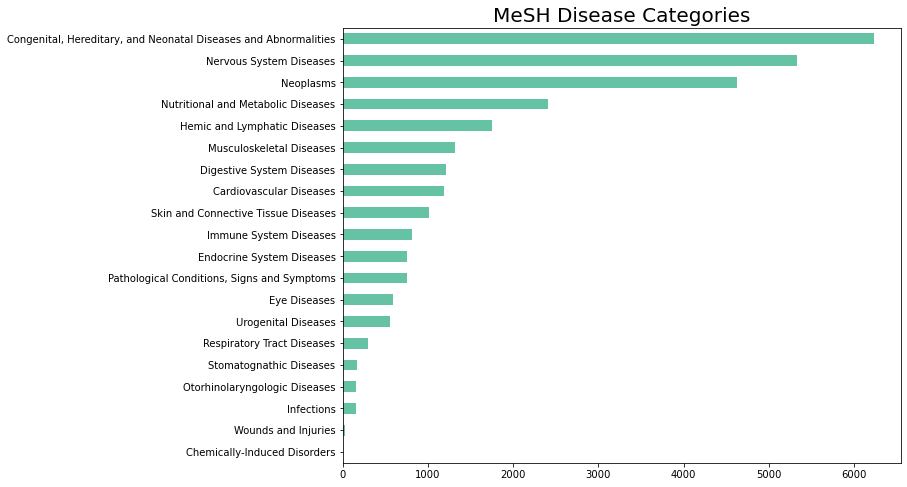

In [96]:
disphase_mesh.disease_category.value_counts(ascending=True).plot(kind='barh', figsize= (10,8))
plt.title("MeSH Disease Categories", fontsize= 20)
plt.show()

# Cuantas proteinas se encuentran asociadas a cada disease?  

In [100]:
# For each mutation add the protein associated
diseases_by_protein = mutation_has_disease.merge(mutation[['id_mutation', 'id_protein']])
diseases_by_protein

,id_mutation,cui,disease_name,id_protein
0,1,C0917800,"Epilepsy, Myoclonic, Infantile",3155
1,1,C0036572,Seizures,3155
2,1,C3892048,"DEAFNESS, AUTOSOMAL DOMINANT 65",3155
3,1,C3463992,"EPILEPTIC ENCEPHALOPATHY, EARLY INFANTILE, 1",3155
4,2,C0917800,"Epilepsy, Myoclonic, Infantile",3155
...,...,...,...,...
2004252,1646277,C1333965,benign fibroma of liver,312
2004253,1601726,C0024121,Lung Neoplasms,5458
2004254,1604591,C0024121,Lung Neoplasms,1300
2004255,1615074,C1302392,Adenoma of small intestine,1876


In [112]:
diseases_by_protein = diseases_by_protein.drop_duplicates(subset= ['disease_name', 'id_protein'])

In [125]:
diseases_by_protein_2 = diseases_by_protein.groupby(['disease_name']).size().sort_values().to_frame().rename(columns= {0: 'protein_count'}).reset_index()

In [126]:
diseases_by_protein_2[diseases_by_protein_2.protein_count == 3]

,disease_name,protein_count
3053,Blindness,3
3054,Developmental regression,3
3055,"Pancreatitis, Chronic",3
3056,Tonic - clonic seizures,3
3057,Idiopathic hypogonadotropic hypogonadism,3
...,...,...
3219,Anemia,3
3220,"MICROCEPHALY, PRIMARY AUTOSOMAL RECESSIVE, 1",3
3221,CIC-DUX Sarcoma,3
3222,Ovarian Angiosarcoma,3


In [119]:
diseases_by_protein[diseases_by_protein.disease_name == 'Anemia']

,id_mutation,cui,disease_name,id_protein
329006,162850,C0002871,Anemia,3379
842332,68975,C0002871,Anemia,4287
842333,147359,C0002871,Anemia,1612


In [127]:
diseases_by_protein_2.describe()

,protein_count
count,4051.000000
mean,80.566527
std,494.782898
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5322.000000


In [138]:
diseases_by_protein_3 = diseases_by_protein_2.groupby('protein_count').size().sort_values().reset_index().rename(columns= {0: 'disease_count'})

In [146]:
diseases_by_protein_3

,protein_count,disease_count
0,318,1
1,625,1
2,629,1
3,634,1
4,636,1
...,...,...
275,6,59
276,4,102
277,3,171
278,2,401


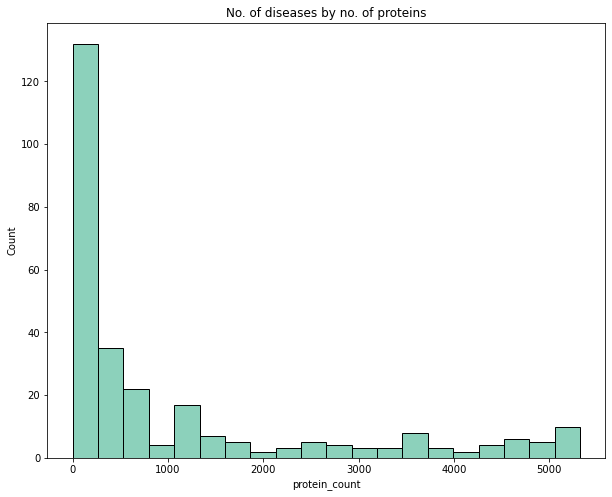

In [154]:
plt.subplots(figsize= (10,8))
sns.histplot(x = 'protein_count', data= diseases_by_protein_3, bins= 20)
plt.title("No. of diseases by no. of proteins")
plt.show()